# Buck Converter Design
**Author:** Ian Eykamp, **Date:** June 27, 2023

### Goals
See the [notebook of the same name](https://github.com/ianeyk/wind-turbine/blob/main/generic_wind_turbine/initial_buck_converter_parameters/buck_converter_parameters.ipynb) under the folder `initial_turbine_buck_converter_parameters` for the walkthrough using the original numbers and more detailed explanations of what I am doing. This notebook closely mirrors the analysis we followed in Labs 9-11 of Power Electronics. This notebook calculates and then tests the final values used in the buck converter and compensator for the UC2844 feedback loop.

### Import Libraries
The `plecs_helper` library is a file in this directory which has some helper functions for getting data out of PLECS and for making nice plots.

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from UliEngineering.EngineerIO import format_value
from si_prefix import si_format
import plecs_helper as helper
%matplotlib
%matplotlib inline

# Imports and setup
from pint import UnitRegistry

# pandas display using scientific notation
# pd.set_option('display.float_format', lambda x: f'{x:.3e}')

# use pint
units = UnitRegistry()
units.default_format = "~P.2f"

def to_db(gain):
    return np.log10(np.abs(gain)) * 20

def to_decibels(gain):
    return to_db(gain)

def from_db(db):
    return 10 ** (db / 20)

Using matplotlib backend: TkAgg


# Schematic

The operation of the buck converter is described elsewhere, not least in the [notebook](https://github.com/ianeyk/wind-turbine/blob/main/generic_wind_turbine/initial_buck_converter_parameters/buck_converter_parameters.ipynb) mentioned previously and [this detailed design document](https://docs.google.com/document/d/1PnPaonVPVxOmpUSNjwdRlw55tw-PfFlrPFVEoT9o3yc/edit). This model has a 30V (per phase) rectified 3-phase voltage source with 14.5Ω internal resistance, an output capacitance of 200uF, a target output current of 0.25A, and separate current-sensing resistors for the ISENSE pin vs. the compensator. The larger output capacitance significantly reduces the phase margin on the transfer function, but the compensator still works well, as documented below.

One other thing to keep in mind is that my feedback loop controls the output current, not voltage; that is, instead of targeting a certain output voltage like we did in Power Electronics, we are targeting a certain current through the second shunt resistor. How I accomplish this using diff amps is described elsewhere.

For this model, I also took care to choose inductor and compensator component values that exist on Digikey. All components are specc'ed in this [Google Sheet](https://docs.google.com/spreadsheets/d/1FKhJxWTBdioV72Y6lbeVeFl75lQ-HYMHbcw-U65tTL4/edit), and the KiCAD schematic is available on my [GitHub](https://github.com/ianeyk/wind-turbine/tree/main/small_wind_turbine/KiCAD/small_wind_turbine). The final PLECS model is [here](https://github.com/ianeyk/wind-turbine/blob/main/small_wind_turbine/3phase_generator_buck_converter.plecs), and the models I used for performing the frequency analyses are [in this folder on GitHub](https://github.com/ianeyk/wind-turbine/tree/main/small_wind_turbine/frequency_analysis_buck_converter).

![Entire PLECS Schematic](plecs_data/current_500mA/schematic_buck_converter_no_offset.png)

### Calculate Inductance
I am nominally aiming for boundary conduction mode (BCM), because this seems like a good balance between limiting the peak inductor voltage and limiting the total energy stored in the inductor.

In [47]:
RT = 7.87 * units.kiloohm
CT = 2.2 * units.nanofarad
Fs = 1.72 / (RT * CT) / 2
R_peak_Isense = 50 * units.milliohm
R_out_Isense = 100 * units.milliohm
R_L = 200 * units.milliohm # currently unused

Cout = 200 * units.microfarad
# Fs = 50 * units.kilohertz
Ts = 1 / Fs
Ibat = 0.25 * units.amp
Rbat = 0.17 * units.ohm
Vg_nominal = 30 * np.sqrt(3) * units.volt
Vbat_nominal = 12 * units.volt
Vout_nominal = Vbat_nominal + Ibat * Rbat
R_generator = 14.5 * units.ohm
Z_eq = Vout_nominal / Ibat
Vg_available = Vg_nominal * Z_eq / (R_generator + Z_eq)
D_nominal = Vout_nominal / Vg_available
Imin = 0 * units.amp
Ipeak = 2 * Ibat - Imin
L = Vout_nominal * (1 - D_nominal) * Ts / Ipeak
L2 = (Vg_available - Vout_nominal) * D_nominal * Ts / Ipeak


print(f"Fs = {Fs.to_compact(units.hertz)}")
print(f"D = {np.round(D_nominal.to_base_units(), 2)}")
print(f"L1 (calculated on downward slope) = {L.to_compact(units.henry)}")
print(f"L2 (claculated on upward slope) = {L2.to_compact(units.henry)}")
print(f"Vout = {Vout_nominal.to_compact(units.volt)}")
print(f"Equivalent impedance = {Z_eq.to_compact(units.ohm)}, meaning generator output voltage = {Vg_available.to_compact(units.volt)} from {Vg_nominal}")

Fs = 49.67 kHz
D = 0.30
L1 (calculated on downward slope) = 338.69 µH
L2 (claculated on upward slope) = 338.69 µH
Vout = 12.04 V
Equivalent impedance = 48.17 Ω, meaning generator output voltage = 39.94 V from 51.96 V


The printouts for L1 and L2 are the same value calculated for the up-going vs. down-going slope of the inductor current. They are expected to be equal for BCM and CCM, which they are. In reality, I am using a 345uH inductor.

### Plant Frequency Analysis
PLECS Model: [`frequency_experiment_9a.plecs`](https://github.com/ianeyk/wind-turbine/blob/main/small_wind_turbine/frequency_analysis_buck_converter/frequency_experiment_9a.plecs)

![Plant Frequency Analysis Schematic](plecs_data/current_500mA/schematic_9a.png)

I plotted the frequency analysis results from my old model. The most relevant difference is that the old model had a 100uF capacitor instead of the 200uF in the new model. The new transfer function is shifted a bit to the left from the old one because of the higher output capacitance.

Lead element center voltage (ω_c): 5.00 kHz


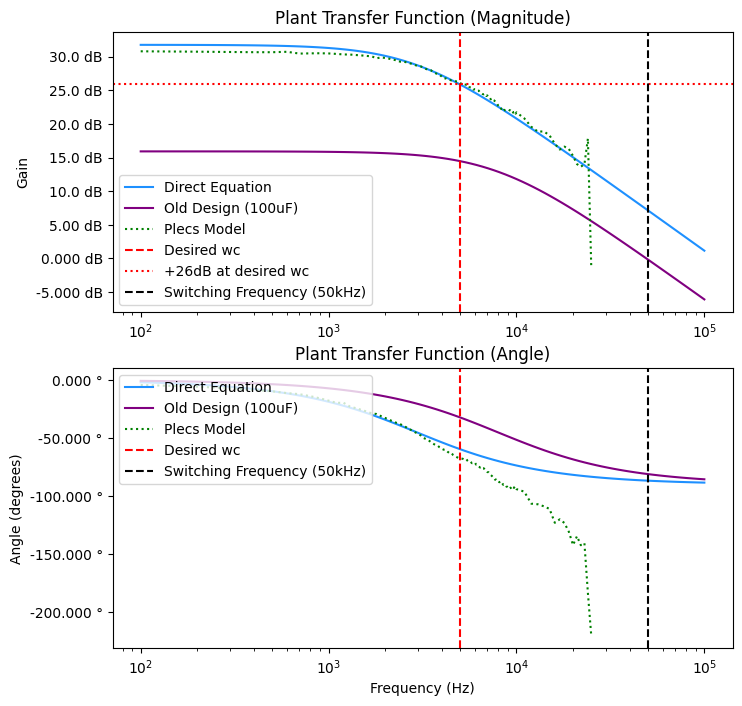

In [48]:
df_plant = pd.read_csv("plecs_data/current_500mA/plant_bode_no_quiescent.csv")
df_plant.set_axis(["w", "CH1", "CH2"], axis = "columns", inplace = True)

expected_wc = 50e3 / 10
print(f"Lead element center voltage (ω_c): {si_format(expected_wc, precision = 2)}Hz")
w = np.logspace(2, 5, 100) # * units.hertz

old_R_Iout_shunt = 5e-3 # * units.ohm
old_Rload = 0.1 # * units.ohm
old_Cload = 200e-6 # * units.farad
old_mystery_factor = 50 # for a total of * 62.5 = 5^4 / 10 = 5^3 / 2
old_theoretical_plant_bode = old_Rload / (1 + (2 * np.pi * 1j * w) * old_Rload * old_Cload) / old_Rload * old_R_Iout_shunt * 25 * old_mystery_factor

new_R_Iout_shunt = R_peak_Isense.to(units.ohm).magnitude
new_Rload = R_out_Isense.to(units.ohm).magnitude + Rbat.to(units.ohm).magnitude
new_Cload = Cout.to(units.farad).magnitude
new_mystery_factor = 31 # 14
theoretical_plant_bode = new_Rload / (1 + (2 * np.pi * 1j * w) * new_Rload * new_Cload) / new_Rload * new_R_Iout_shunt * 25 * new_mystery_factor

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (8, 8))
helper.axes_labels("", "Hz", "Gain", "dB", title = "Plant Transfer Function (Magnitude)", ax = ax1)
ax1.semilogx(w, to_decibels(theoretical_plant_bode), linestyle = "solid", color = "dodgerblue", label = "Direct Equation")
ax1.semilogx(w, to_decibels(old_theoretical_plant_bode), linestyle = "solid", color = "purple", label = "Old Design (100uF)")
ax1.semilogx(df_plant["w"], df_plant["CH1"], linestyle = "dotted", color = "green", label = "Plecs Model")
ax1.axvline(x = expected_wc, linestyle = "dashed", color = "red", label = "Desired wc")
ax1.axhline(y = 26, linestyle = "dotted", color = "red", label = "+26dB at desired wc")
ax1.axvline(x = 50e3, linestyle = "dashed", color = "black", label = "Switching Frequency (50kHz)")
ax1.legend(loc = "lower left")

helper.axes_labels("Frequency (Hz)", "Hz", "Angle (degrees)", "°", title = "Plant Transfer Function (Angle)", ax = ax2)
ax2.semilogx(w, np.angle(theoretical_plant_bode, deg = True), linestyle = "solid", color = "dodgerblue", label = "Direct Equation")
ax2.semilogx(w, np.angle(old_theoretical_plant_bode, deg = True), linestyle = "solid", color = "purple", label = "Old Design (100uF)")
ax2.semilogx(df_plant["w"], df_plant["CH2"], linestyle = "dotted", color = "green", label = "Plecs Model")
ax2.axvline(x = expected_wc, linestyle = "dashed", color = "red", label = "Desired wc")
ax2.axvline(x = 50e3, linestyle = "dashed", color = "black", label = "Switching Frequency (50kHz)")
ax2.legend(loc = "upper left")

Ok, so the PLECS model matches the theory pretty well. I decided on a target crossover frequency of 5kHz for the current model, instead of 6.25kHz in the previous model. It will respond slightly slower but have a slightly better phase margin. Because of the larger output capacitance, the phase margin is way smaller (-60deg vs. -30deg). This can be compensated for (get it?) with a larger lead element.

### Finding the compensator values
**Using code copied from Lab 11**

Design parameters are a gain cross-over frequency at 5kHz, gain factor of -26dB to make the gain crossover occur at that frequency (obtained from the simulated transfer function above), and phase boost of 60 degrees. I used a Type II compensator consisting of an integrating pole and a lead element like we used in class for the buck-boost converter.

In [49]:
class Compensator:
    def __init__(self, angle_boost_degrees, Kp_decibel_attenuation, Rf1_unitless):
        self.Rf1 = Rf1_unitless * units.ohm
        self.angle_boost = angle_boost_degrees * units.degree
        self.Kp = 1 / from_db(Kp_decibel_attenuation)
        self.find_values()

    def __repr__(self) -> str:
        return f"K: {self.K},\t Gc0: {self.Gc0.to_compact()},\t Rf1: {self.Rf1.to_compact(units.ohm)},\t Rc1: {self.Rc1.to_compact(units.ohm)},\t Cc1: {self.Cc1.to_compact(units.farad)},  \t Cc2: {self.Cc2.to_compact(units.farad)}"

    def find_values(self):
        self.wc = 50 * units.kilohertz * units.revolutions / 10

        # self.angle_boost = 60 * units.degree
        self.K = np.tan((self.angle_boost / 2 + 45 * units.degree))
        # self.Kp = 1 / from_db(26) # from_db(19) # from_db(13) # from_db(32)
        self.wz = self.wc / self.K
        self.wp = self.wc * self.K
        self.Gc0 = self.Kp * self.wc * np.sqrt((1 + self.K ** (-2)) / (1 + self.K ** 2))
        self.Cc1 = 1 / (self.Gc0 * self.Rf1)
        self.Rc1 = 1 / (self.wz * self.Cc1)
        self.Cc2 = 1 / (self.wp * self.Rc1)

for R in [2, 2.2, 2.26, 2.7, 3.3, 3.9, 4.3, 4.7, 4.87, 5.1, 5.6, 6.2, 6.34, 6.8, 7.5, 8.2, 10]: # values to try in kiloohms
    R_to_highlight = 5.1
    if R == R_to_highlight:
        print() # highlight the chosen value
    compensator = Compensator(angle_boost_degrees = 60, Kp_decibel_attenuation = 26, Rf1_unitless = R * 1e3)
    print(compensator)
    if R == R_to_highlight:
        print()

K: 3.73,	 Gc0: 67.15 Hz·turn,	 Rf1: 2.00 kΩ,	 Rc1: 100.24 Ω,	 Cc1: 1.19 µF,  	 Cc2: 85.09 nF
K: 3.73,	 Gc0: 67.15 Hz·turn,	 Rf1: 2.20 kΩ,	 Rc1: 110.26 Ω,	 Cc1: 1.08 µF,  	 Cc2: 77.35 nF
K: 3.73,	 Gc0: 67.15 Hz·turn,	 Rf1: 2.26 kΩ,	 Rc1: 113.27 Ω,	 Cc1: 1.05 µF,  	 Cc2: 75.30 nF
K: 3.73,	 Gc0: 67.15 Hz·turn,	 Rf1: 2.70 kΩ,	 Rc1: 135.32 Ω,	 Cc1: 877.88 nF,  	 Cc2: 63.03 nF
K: 3.73,	 Gc0: 67.15 Hz·turn,	 Rf1: 3.30 kΩ,	 Rc1: 165.39 Ω,	 Cc1: 718.26 nF,  	 Cc2: 51.57 nF
K: 3.73,	 Gc0: 67.15 Hz·turn,	 Rf1: 3.90 kΩ,	 Rc1: 195.46 Ω,	 Cc1: 607.76 nF,  	 Cc2: 43.64 nF
K: 3.73,	 Gc0: 67.15 Hz·turn,	 Rf1: 4.30 kΩ,	 Rc1: 215.51 Ω,	 Cc1: 551.23 nF,  	 Cc2: 39.58 nF
K: 3.73,	 Gc0: 67.15 Hz·turn,	 Rf1: 4.70 kΩ,	 Rc1: 235.56 Ω,	 Cc1: 504.31 nF,  	 Cc2: 36.21 nF
K: 3.73,	 Gc0: 67.15 Hz·turn,	 Rf1: 4.87 kΩ,	 Rc1: 244.08 Ω,	 Cc1: 486.71 nF,  	 Cc2: 34.94 nF

K: 3.73,	 Gc0: 67.15 Hz·turn,	 Rf1: 5.10 kΩ,	 Rc1: 255.61 Ω,	 Cc1: 464.76 nF,  	 Cc2: 33.37 nF

K: 3.73,	 Gc0: 67.15 Hz·turn,	 Rf1: 5.60 kΩ,	 Rc1: 280

The highlighted row yields nice capacitance values fo 33nF and 470nF, which are easily available. Resistors are chosen at 5.10kΩ and 255Ω, respectively.

### Compensator Transfer Function
PLECS Model: [`frequency_experiment_compensator_only.plecs`](https://github.com/ianeyk/wind-turbine/blob/main/small_wind_turbine/frequency_analysis_buck_converter/frequency_experiment_compensator_only.plecs)

![Compensator Schematic](plecs_data/current_500mA/schematic_compensator_compact.png)

I ran the frequency analysis in PLECS to determine the transfer function, as well as writing down the equation based on the components. They match exactly.

Lead element center voltage (ω_c): 5.00 kHz


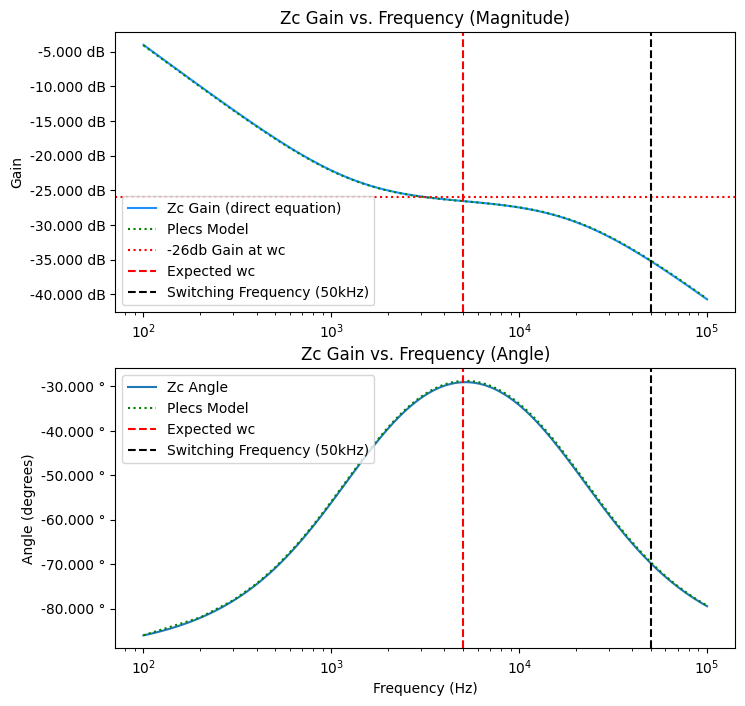

In [50]:
df_compensator = pd.read_csv("plecs_data/current_500mA/compensator_bode.csv")
df_compensator.set_axis(["w", "CH1", "CH2"], axis = "columns", inplace = True)

# chosen values
compensator = Compensator(angle_boost_degrees = 60, Kp_decibel_attenuation = 26, Rf1_unitless = 5.1 * 1e3)
Rf1 = compensator.Rf1.to(units.ohm).magnitude
Rc1 = compensator.Rc1.to(units.ohm).magnitude
Cc1 = compensator.Cc1.to(units.farad).magnitude
Cc2 = compensator.Cc2.to(units.farad).magnitude
expected_wc = 1 / (Rc1 * np.sqrt(Cc1 * Cc2)) / 2 / np.pi # to get it into Hz
print(f"Lead element center voltage (ω_c): {si_format(expected_wc, precision = 2)}Hz")

w = np.logspace(2, 5, 100) # * units.hertz
def get_Zc(my_w):
    my_Zc = 1 / (1 / (Rc1 + 1 / (2 * np.pi * 1j * my_w * Cc1)) + 1 / (1 / (2 * np.pi * 1j * my_w * Cc2))) / Rf1 # kOhm
    return my_Zc
Zc = get_Zc(w) # direct equation

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (8, 8))
helper.axes_labels("", "Hz", "Gain", "dB", title = "Zc Gain vs. Frequency (Magnitude)", ax = ax1)
ax1.semilogx(w, to_decibels(Zc), linestyle = "solid", color = "dodgerblue", label = "Zc Gain (direct equation)")
ax1.semilogx(df_compensator["w"], df_compensator["CH1"], linestyle = "dotted", color = "green", label = "Plecs Model")
ax1.axhline(y = -26, linestyle = "dotted", color = "red", label = "-26db Gain at wc")
ax1.axvline(x = expected_wc, linestyle = "dashed", color = "red", label = "Expected wc")
ax1.axvline(x = 50e3, linestyle = "dashed", color = "black", label = "Switching Frequency (50kHz)")
ax1.legend(loc = "lower left")

helper.axes_labels("Frequency (Hz)", "Hz", "Angle (degrees)", "°", title = "Zc Gain vs. Frequency (Angle)", ax = ax2)
ax2.semilogx(w, np.angle(Zc, deg = True), linestyle = "solid", label = "Zc Angle")
ax2.semilogx(df_compensator["w"], df_compensator["CH2"] - 180, linestyle = "dotted", color = "green", label = "Plecs Model")
ax2.axvline(x = expected_wc, linestyle = "dashed", color = "red", label = "Expected wc")
ax2.axvline(x = 50e3, linestyle = "dashed", color = "black", label = "Switching Frequency (50kHz)")
ax2.legend(loc = "upper left")

### Open-Loop Transfer Function
PLECS Model: [`frequency_experiment_10a.plecs`](https://github.com/ianeyk/wind-turbine/blob/main/small_wind_turbine/frequency_analysis_buck_converter/frequency_experiment_10a.plecs)

![Open-Loop Schematic](plecs_data/current_500mA/schematic_10a.png)

It looks good! After much debugging of the circuit, I got the transfer function in PLECS to match the expected open-loop transfer function, which is the product of transfer functions for the plant and the compensator. I think my issues were due to trying to use the rightmost shunt resistor for the ISENSE pin on the UC2844, which acted strangely because it is to the right of the capacitor.

In any case, we have an open-loop transfer function that looks good and matches expectations. It has infinite gain at DC, a gain crossover frequency at 5kHz as requested, a fat phase margin at the crossover frequency, and strong attenuation at high frequencies. The phase plot falls off a lot faster than expected after the gain crossover frequency, but this is of no real importance to us because the gain margin at the phase crossover frequency is on the order of -15dB.

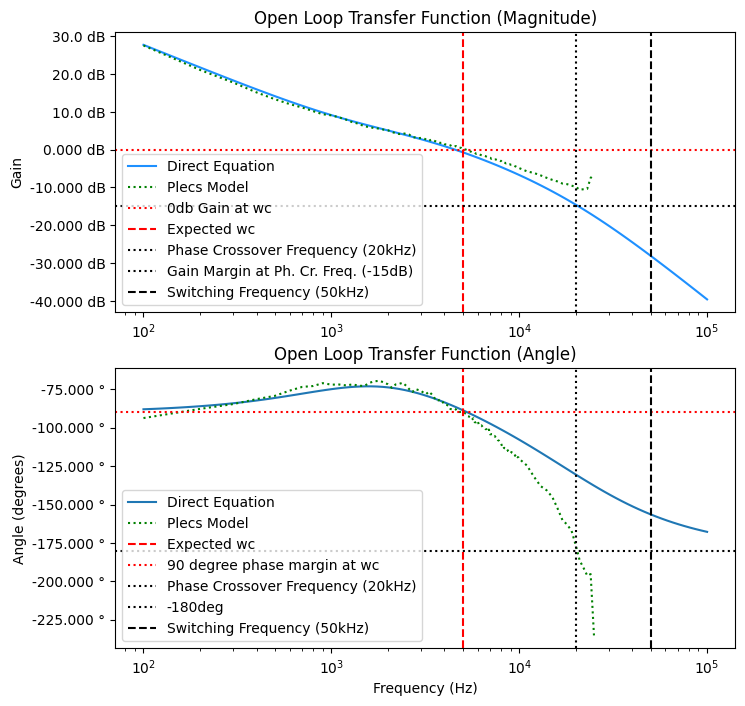

In [51]:
# df_open_loop = pd.read_csv("plecs_data/current_500mA/open_loop_bode_no_quiescent.csv")
df_open_loop = pd.read_csv("plecs_data/current_500mA/open_loop_bode.csv")
df_open_loop.set_axis(["w", "CH1", "CH2"], axis = "columns", inplace = True)

theoretical_open_loop = theoretical_plant_bode * Zc

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (8, 8))
helper.axes_labels("", "Hz", "Gain", "dB", title = "Open Loop Transfer Function (Magnitude)", ax = ax1)
ax1.semilogx(w, to_decibels(theoretical_open_loop), linestyle = "solid", color = "dodgerblue", label = "Direct Equation")
ax1.semilogx(df_open_loop["w"], df_open_loop["CH1"], linestyle = "dotted", color = "green", label = "Plecs Model")
ax1.axhline(y = 0, linestyle = "dotted", color = "red", label = "0db Gain at wc")
ax1.axvline(x = expected_wc, linestyle = "dashed", color = "red", label = "Expected wc")
ax1.axvline(x = 20e3, linestyle = "dotted", color = "black", label = "Phase Crossover Frequency (20kHz)")
ax1.axhline(y = -15, linestyle = "dotted", color = "black", label = "Gain Margin at Ph. Cr. Freq. (-15dB)")
ax1.axvline(x = 50e3, linestyle = "dashed", color = "black", label = "Switching Frequency (50kHz)")
ax1.legend(loc = "lower left")

helper.axes_labels("Frequency (Hz)", "Hz", "Angle (degrees)", "°", title = "Open Loop Transfer Function (Angle)", ax = ax2)
ax2.semilogx(w, np.angle(theoretical_open_loop, deg = True), linestyle = "solid", label = "Direct Equation")
ax2.semilogx(df_open_loop["w"], df_open_loop["CH2"], linestyle = "dotted", color = "green", label = "Plecs Model")
ax2.axvline(x = expected_wc, linestyle = "dashed", color = "red", label = "Expected wc")
ax2.axhline(y = -90, linestyle = "dotted", color = "red", label = "90 degree phase margin at wc")
ax2.axvline(x = 20e3, linestyle = "dotted", color = "black", label = "Phase Crossover Frequency (20kHz)")
ax2.axhline(y = -180, linestyle = "dotted", color = "black", label = "-180deg")
ax2.axvline(x = 50e3, linestyle = "dashed", color = "black", label = "Switching Frequency (50kHz)")
ax2.legend(loc = "lower left")

### Closed-Loop Transfer Function
PLECS Model: Same as open-loop [`frequency_experiment_10a.plecs`](https://github.com/ianeyk/wind-turbine/blob/main/small_wind_turbine/frequency_analysis_buck_converter/frequency_experiment_10a.plecs) except flip the switch from the open-loop side to the closed-loop side on the Analog Discovery model.

![Closed-Loop Schematic](plecs_data/current_500mA/schematic_10b.png)

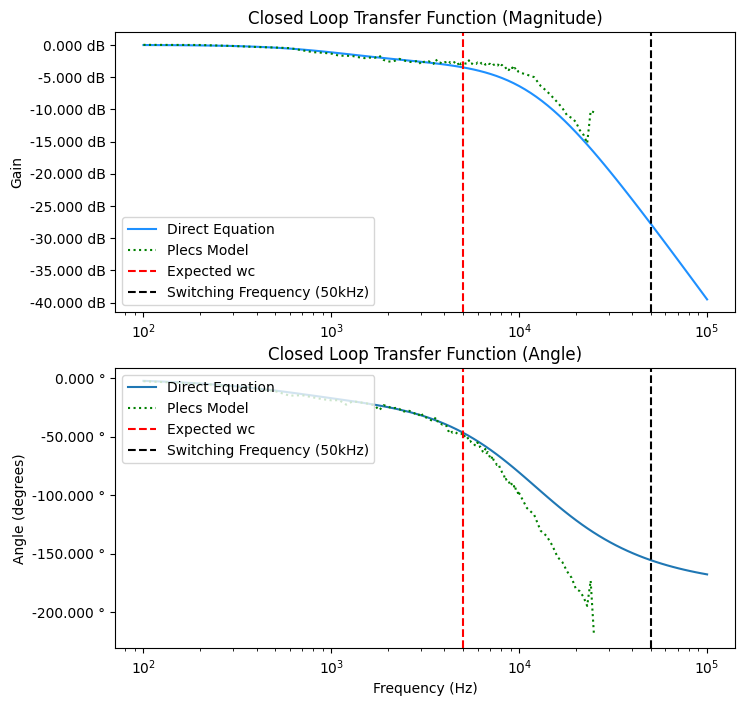

In [52]:
df_closed_loop = pd.read_csv("plecs_data/current_500mA/closed_loop_bode_no_quiescent.csv")
# df_closed_loop = pd.read_csv("plecs_data/current_500mA/closed_loop_bode.csv")
df_closed_loop.set_axis(["w", "CH1", "CH2"], axis = "columns", inplace = True)

theoretical_closed_loop = theoretical_open_loop / (1 + theoretical_open_loop)

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (8, 8))
helper.axes_labels("", "Hz", "Gain", "dB", title = "Closed Loop Transfer Function (Magnitude)", ax = ax1)
ax1.semilogx(w, to_decibels(theoretical_closed_loop), linestyle = "solid", color = "dodgerblue", label = "Direct Equation")
ax1.semilogx(df_closed_loop["w"], df_closed_loop["CH1"], linestyle = "dotted", color = "green", label = "Plecs Model")
ax1.axvline(x = expected_wc, linestyle = "dashed", color = "red", label = "Expected wc")
ax1.axvline(x = 50e3, linestyle = "dashed", color = "black", label = "Switching Frequency (50kHz)")
ax1.legend(loc = "lower left")

helper.axes_labels("Frequency (Hz)", "Hz", "Angle (degrees)", "°", title = "Closed Loop Transfer Function (Angle)", ax = ax2)
ax2.semilogx(w, np.angle(theoretical_closed_loop, deg = True), linestyle = "solid", label = "Direct Equation")
ax2.semilogx(df_closed_loop["w"], df_closed_loop["CH2"], linestyle = "dotted", color = "green", label = "Plecs Model")
ax2.axvline(x = expected_wc, linestyle = "dashed", color = "red", label = "Expected wc")
ax2.axvline(x = 50e3, linestyle = "dashed", color = "black", label = "Switching Frequency (50kHz)")
ax2.legend(loc = "upper left")

Again, the theory and the PLECS model match pretty well. The system has a gain of 1 at DC and strong attenuation well before the switching frequency, exactly as we want.

### Time Response
Lastly, I implemented a square wave signal to the voltage adder to simulate a change in the desired current. The [PLECS model](https://github.com/ianeyk/wind-turbine/blob/main/small_wind_turbine/3phase_generator_buck_converter.plecs) is the same model shown at the start of this notebook.

![Entire PLECS Schematic](plecs_data/current_500mA/schematic_buck_converter.png)


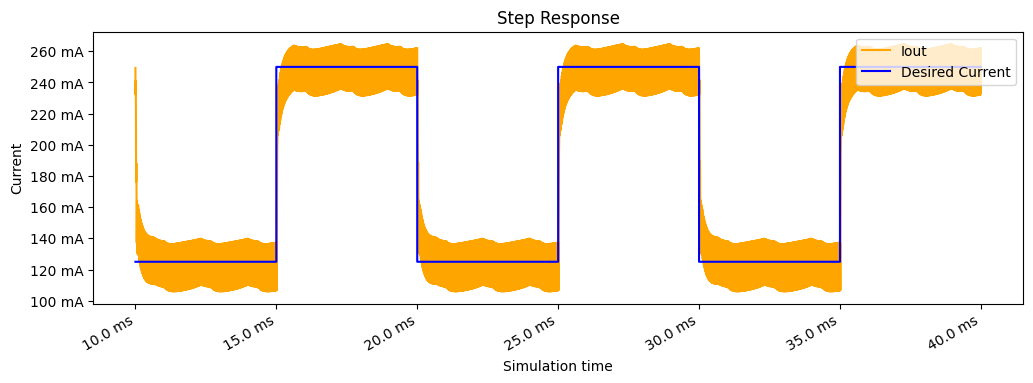

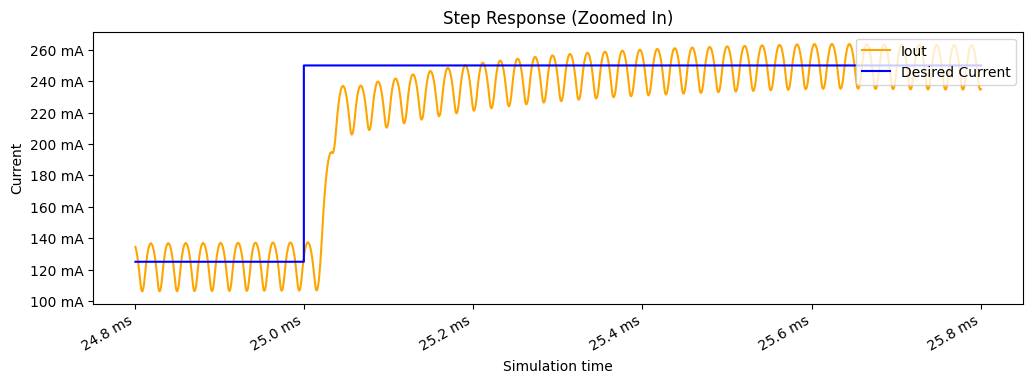

In [53]:
df = pd.read_csv("plecs_data/current_500mA/square_wave_response_lower_current.csv")
df.rename(mapper = helper.strip_labels, axis = "columns", inplace = True)
df["Iexpected"] = .5 * (1 - df["Pulse Generator"] / 2.5) - 0.25
df_zoom = df.loc[(df["Time / s"] > 10e-3) & (df["Time / s"] < 40e-3)]

fig, (ax1) = plt.subplots(nrows = 1, ncols = 1, sharex = True, sharey = False, figsize = (12, 4))
# ax2 = ax1.twinx()
fig.autofmt_xdate()
ax1.plot(df_zoom["Time / s"], df_zoom["Iout"], color = "orange", label = "Iout")
ax1.plot(df_zoom["Time / s"], df_zoom["Iexpected"], color = "blue", label = "Desired Current")
helper.axes_labels("Simulation time", "s", "Current", "A", title = "Step Response", ax = ax1)
ax1.legend(loc = "upper right")

df_zoom = df.loc[(df["Time / s"] > 24.8e-3) & (df["Time / s"] < 25.8e-3)]

fig, (ax1) = plt.subplots(nrows = 1, ncols = 1, sharex = True, sharey = False, figsize = (12, 4))
# ax2 = ax1.twinx()
fig.autofmt_xdate()
helper.axes_labels("Simulation time", "s", "Current", "A", title = "Step Response (Zoomed In)", ax = ax1)
ax1.plot(df_zoom["Time / s"], df_zoom["Iout"], color = "orange", label = "Iout")
ax1.plot(df_zoom["Time / s"], df_zoom["Iexpected"], color = "blue", label = "Desired Current")
ax1.legend(loc = "upper right")

The output current adjusts to the specified value within about half a millisecond, which is fast enough for my application.

The 200uF output capacitor keeps the small-scale current ripple within about 40mA peak-to-peak, which is highly desirable. In the top graph, you can also see some ripple on the 2ms time scale. This corresponds to peaks and troughs in the input voltage due to the 3-phase AC voltage source and subsequent rectification. It is small enough to be very manageable.